In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA, ARMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
from AutoValidator.DataSplitting import split_data

In [3]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')

In [4]:
from AutoValidator.model_tester import ModelTester

# Exploration

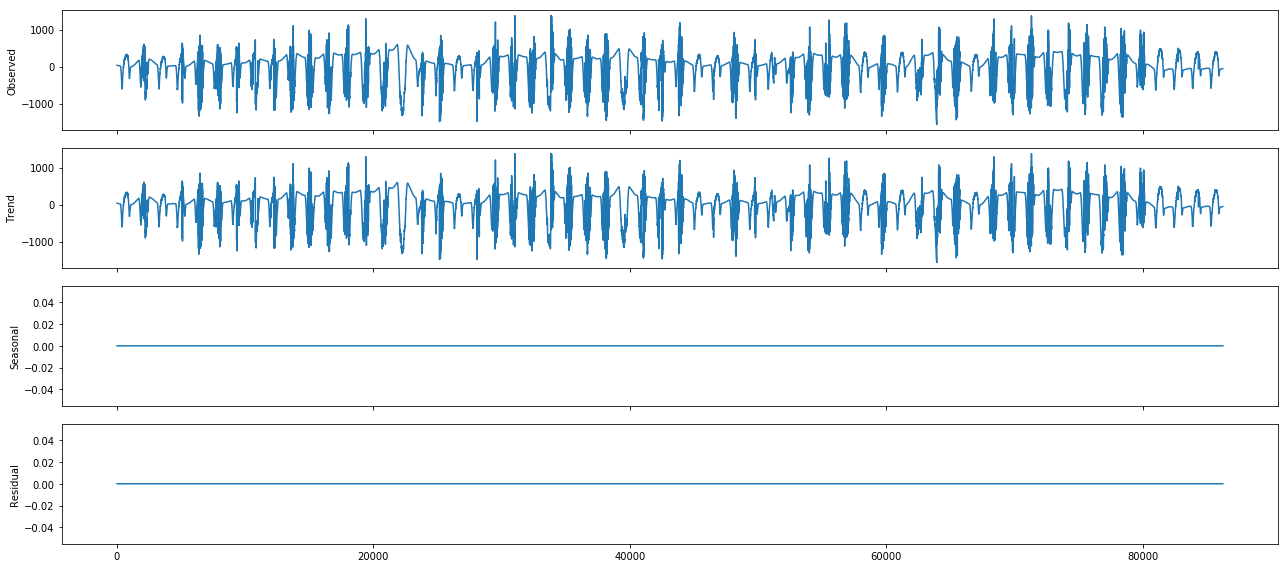

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data['window_1_0'], model='additive', freq=1)
fig = decomposition.plot()
plt.show()

# Model Creation

## 1 minute horizon

In [47]:
arma_model = ARMA(data['window_1_0'][5000:6000], order=(5,1))

In [48]:
model_fit = arma_model.fit(maxiter=100)

In [49]:
model_fit.mle_retvals

{'fopt': 5.326385105352241,
 'gopt': array([ 0.00000000e+00,  7.99360578e-07,  1.15463195e-06,  7.99360578e-07,
         1.77635684e-07, -3.55271368e-07,  2.66453526e-07]),
 'fcalls': 408,
 'warnflag': 0,
 'converged': True,
 'iterations': 33}

In [16]:
model_fit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,99.5312,68.840,1.446,0.149,-35.393,234.455
ar.L1.window_1_0,2.1529,0.034,63.066,0.000,2.086,2.220
ar.L2.window_1_0,-1.3557,0.076,-17.894,0.000,-1.504,-1.207
ar.L3.window_1_0,0.0521,0.085,0.611,0.541,-0.115,0.219
ar.L4.window_1_0,0.1152,0.076,1.522,0.128,-0.033,0.263
ar.L5.window_1_0,0.0340,0.033,1.044,0.297,-0.030,0.098
ma.L1.window_1_0,-0.9273,0.015,-62.251,0.000,-0.957,-0.898


<IPython.core.display.Javascript object>


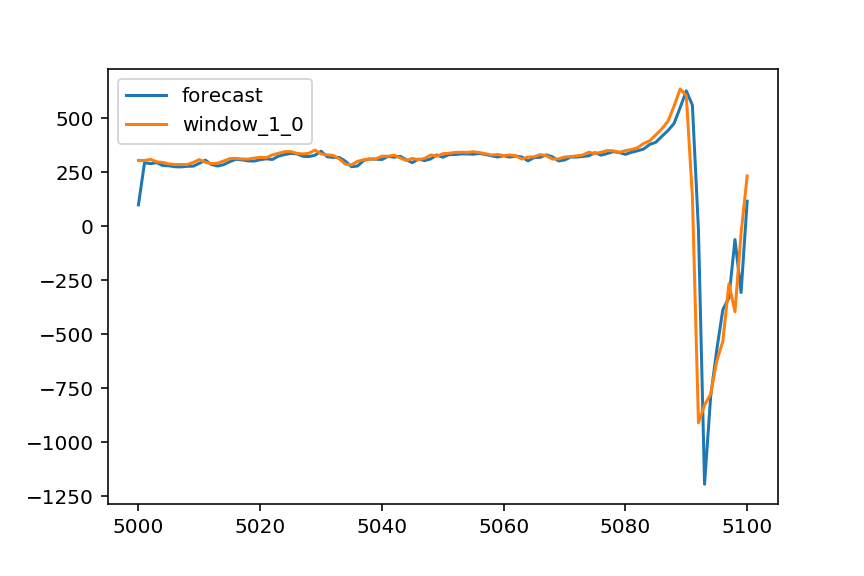

In [66]:
err = model_fit.plot_predict(start=0, end=100)

<IPython.core.display.Javascript object>


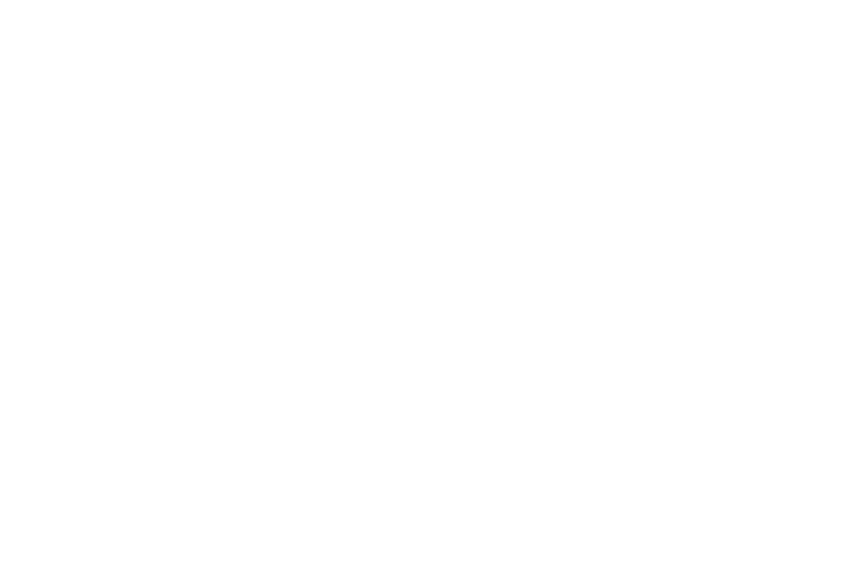

ValueError: Length of passed values is 4001, index implies 1

In [65]:
# pred = arma_model.predict(params=model_fit.params)

pred = model_fit.predict(start=0, end=100)

# err = arma_model.geterrors(params=model_fit.params)
# pred_ci = arma_model.  .conf_int(data['window_1_0'][6000:7000].values)

In [64]:
pred.shape, err.shape

((101,), (7, 2))

<IPython.core.display.Javascript object>


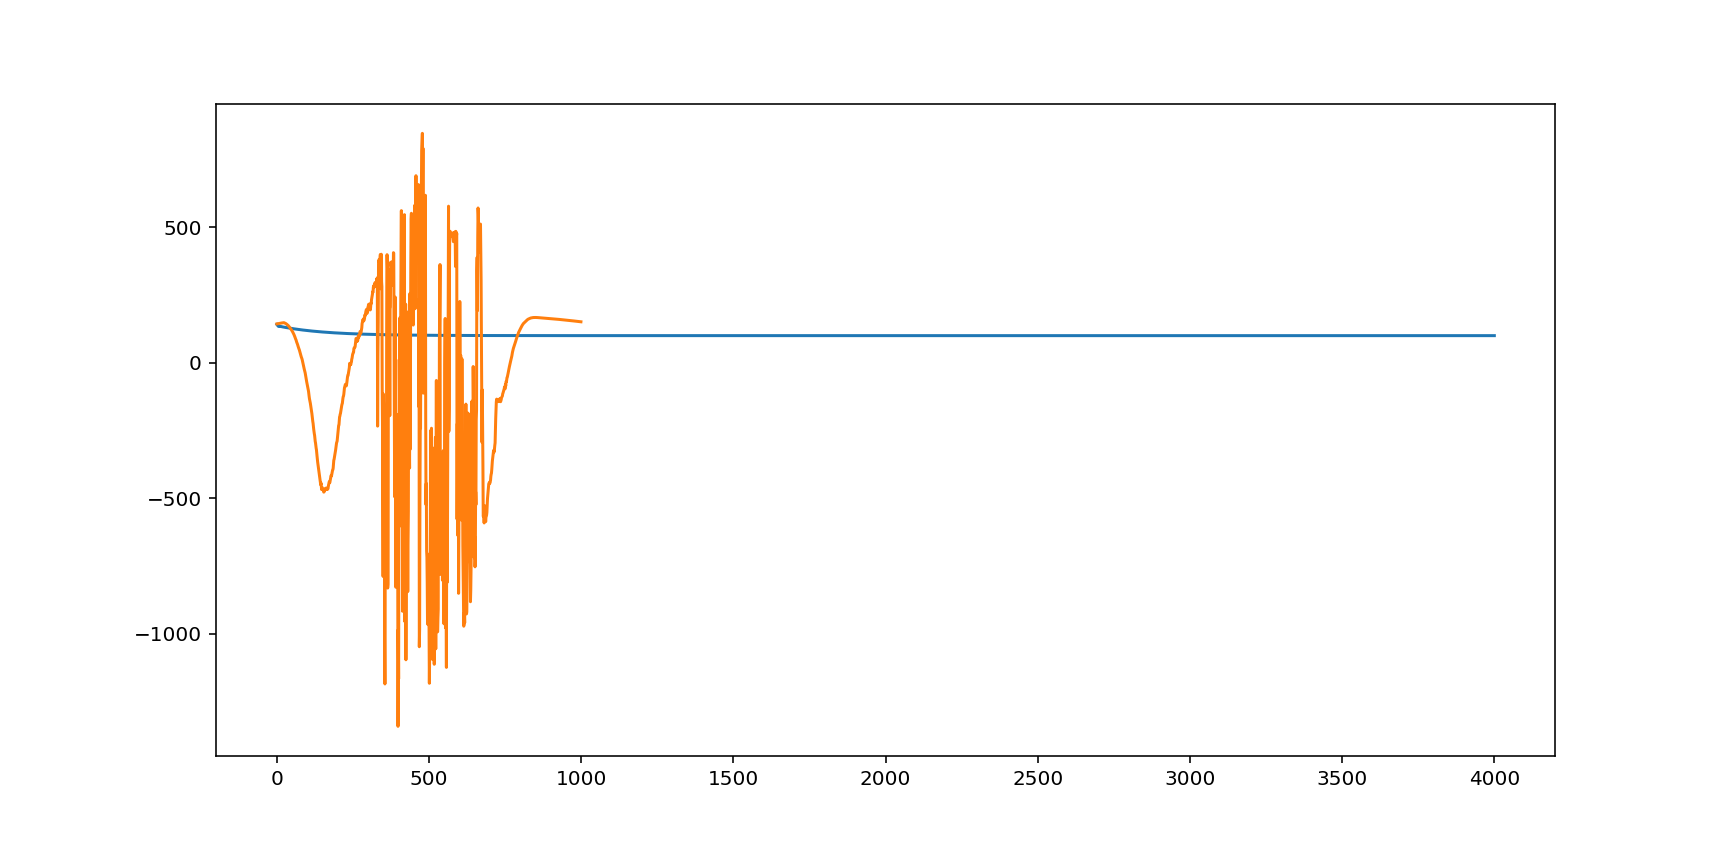

In [53]:
%matplotlib notebook

plt.figure(figsize=(12, 6))
plt.plot(pred)
plt.plot(data['window_1_0'][6000:7000].values)
# plt.fill_between(pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], alpha=0.2, color='k')

In [17]:
output

tuple

In [5]:
tester = ModelTester(data, 1, 0.20)


tester.add_model()

results = tester.test_models()

NameError: name 'walk' is not defined

## 5 minute horizon

In [109]:
from utils.progress import ProgressBar

In [112]:
def backtest(data: np.ndarray, start: float, test_step_size: int):
    """
    Splits a dataset into a train and test set using backtesting with a set size of each test set and a % of data heldout to
    always be in the train set.
    
    data -> A numpy array of pandas dataframe of the data to split
    start -> a value in [0, 1] of the % of data to always be in the train set
    test_step_size -> The size of each test split
    """
    step = test_step_size
    start = int(start * len(data))
    splits = np.arange(start, len(data), step)
    
    train, test = [], []
    
    for test_start, test_end in zip(splits[:-1], splits[1:]):
#         train += [data[:test_start]]
#         test += [data[test_start:test_end]]
        
        yield data[:test_start], data[test_start:test_end]
        
    return

In [210]:
results = []
conf_int = []

horizon = 5
back_horizon = 2000 

In [213]:
data['window_1_0'] = data['window_1_0'][:10000]

In [214]:
# Create the model
# Use a sliding window of 500 samples
# Train then forecast 5
bar = ProgressBar()
bar.set_length(len(data['window_1_0']) * 0.8 // horizon)
print(len(data['window_1_0']) * 0.8 // horizon)
i = 0
for train, test in backtest(data['window_1_0'], 0.2, horizon):
    arma_model = ARMA(train[-back_horizon:], order=(5, 1))
    arma_model_res = arma_model.fit()
    
    results += [arma_model_res.forecast(horizon)[0]]
#     conf_int += [arma_model_res.forecast(horizon)[1]]
    bar.progress()
    
#     %matplotlib notebook
#     plt.plot(train[-back_horizon:].values, label='train')
#     plt.plot(np.arange(horizon) + back_horizon, results[0], label='pred')
#     plt.plot(np.arange(horizon) + back_horizon, test.values, label='actual')
# #     plt.fill_between(conf_int[0][:, 0], conf_int[0][:, 1], alpha=0.2, color='k')
#     plt.legend()
#     break
    
#     i += 1
#     if i > 100:
#         break

13801.0


c:\program files\python36\lib\site-packages\statsmodels\base\data.py:131: RuntimeWarning:

invalid value encountered in reduce



MissingDataError: exog contains inf or nans

In [171]:
pred = np.hstack(results).flatten()

<IPython.core.display.Javascript object>


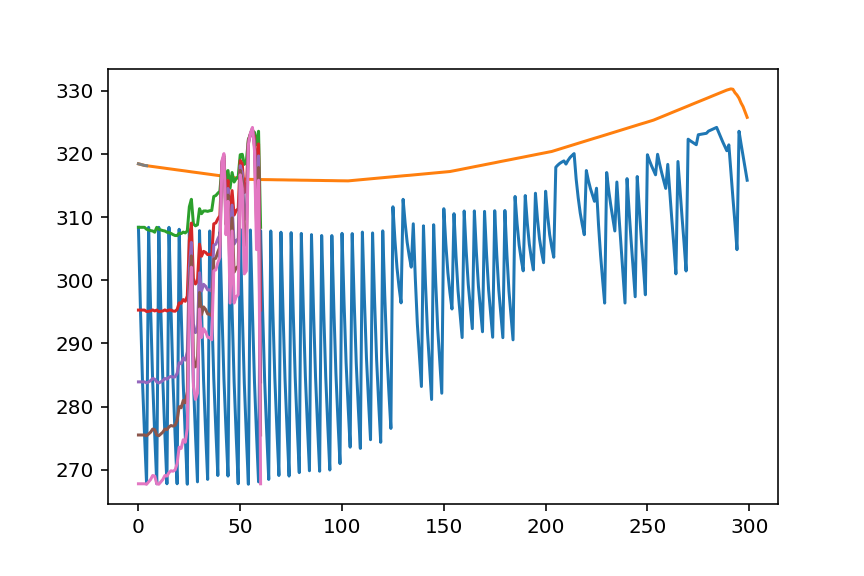

In [175]:
%matplotlib notebook
plt.plot(pred)
a = int(0.2 * len(data['window_1_0']))
plt.plot(np.arange(len(pred)), data['window_1_0'][a:a+len(pred)])

In [137]:
pred, std = [], []
for i, x in enumerate(results):
    if i % 3 == 0:
        pred += [x]
    if i % 3 == 1:
        std += [x]

In [143]:
pred = np.vstack(pred).flatten()

In [144]:
len(pred), len(data['window_1_0'][int(0.2 * len(data['window_1_0'])):])

(69005, 69007)

<IPython.core.display.Javascript object>


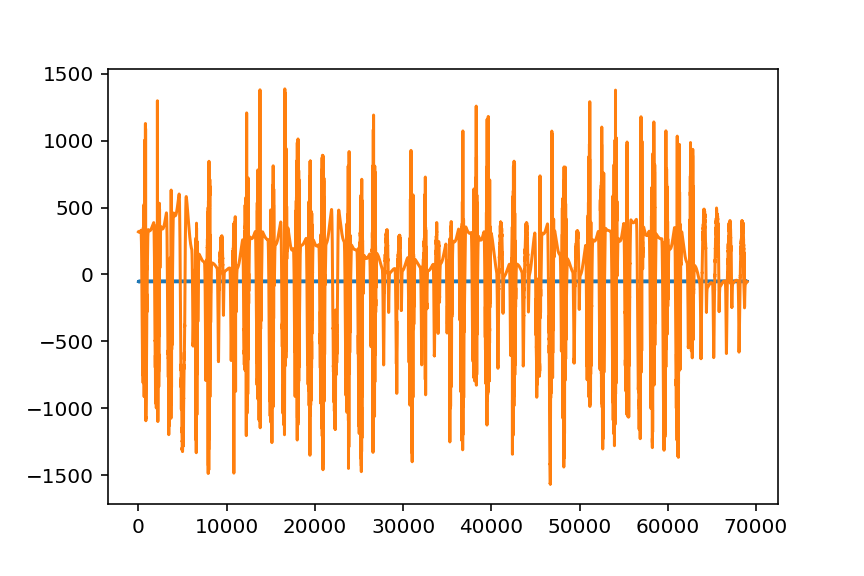

In [146]:
%matplotlib notebook
plt.plot(pred)
plt.plot(np.arange(len(pred) + 2), data['window_1_0'][int(0.2 * len(data['window_1_0'])):])

In [81]:
arma_model = ARMA(data['window_1_0'], order=(5,1))

In [82]:
import datetime

In [83]:
start = datetime.datetime.now()
five_min_model_fit = arma_model.fit(maxiter=100)
print(datetime.datetime.now() - start)

0:01:55.822754


In [99]:
pred, std, conf_int = five_min_model_fit.forecast(5000)

In [100]:
pred

array([-53.25422201, -52.56544909, -51.97433384, ...,   0.25478287,
         0.25478287,   0.25478287])

In [101]:
std

array([ 93.24956409, 133.9696312 , 156.46037248, ..., 371.93974062,
       371.93974062, 371.93974062])

In [102]:
pred - std

array([-146.5037861 , -186.53508029, -208.43470633, ..., -371.68495776,
       -371.68495776, -371.68495776])

In [103]:
conf_int

array([[-236.02000921,  129.51156519],
       [-315.14110126,  210.01020308],
       [-358.63102892,  254.68236124],
       ...,
       [-728.73371318,  729.24327891],
       [-728.73371318,  729.24327891],
       [-728.73371318,  729.24327891]])

In [106]:
plt.plot(data['window_1_0'])
plt.plot(np.arange(len(pred)) + data['window_1_0'].index[-1], pred)

# plt.fill_between(np.arange(5) + data['window_1_0'].index[-1], conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='k')
plt.fill_between(np.arange(len(pred)) + data['window_1_0'].index[-1], pred - std, pred + std, alpha=0.2, color='k')

<IPython.core.display.Javascript object>


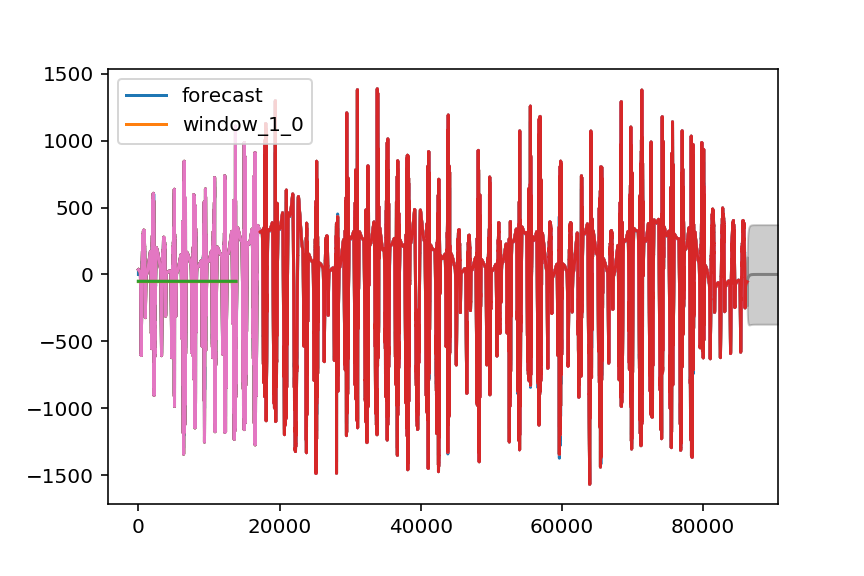

<IPython.core.display.Javascript object>


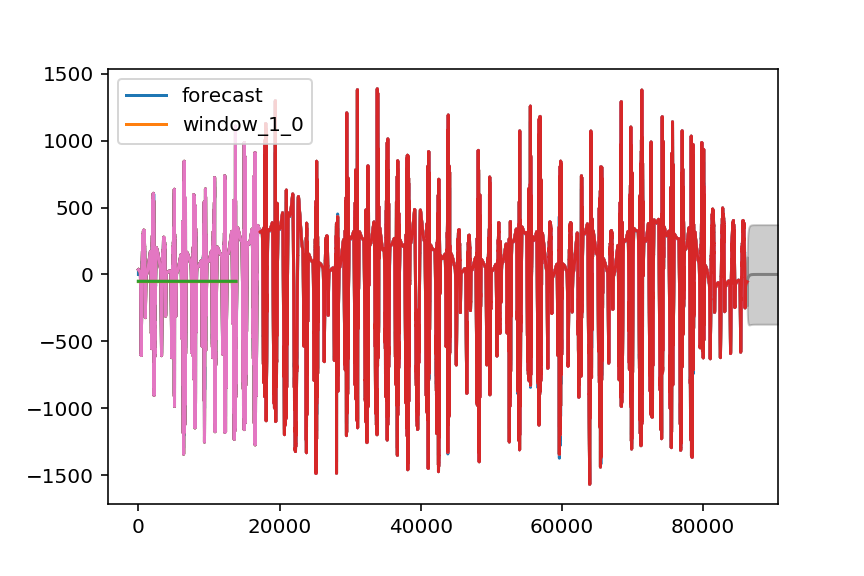

In [97]:
five_min_model_fit.plot_predict()

## 60 minute horizon

In [26]:
data = pd.read_csv("data.csv")
print(len(data))
data = data[: 100 * 1000]

1294559


In [27]:
len(data)

100000

### Plot the data 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


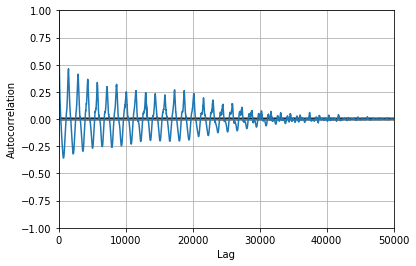

In [17]:
autocorrelation_plot(data)

In [56]:
def split(data, splits = 10, offset = 0, ratio = 0.2):
    result = []
    
    for i in range(0, splits):
        start = int( offset + (i / splits) * (len(data) - offset)   )
        end   = int( offset + ((i + 1) / splits) * (len(data) - offset) )
        print(start, end)
        
        tempData = data[start: end]
        train, test = tempData[0: int(0.8 * len(tempData))], tempData[int(0.8 * len(tempData)):] 
        
        result.append((train, test))
        
    return result

In [73]:
splits = 5

trainingSets = split(data.values, 20, 50000)
# train, test = data.values[0: int(0.8 * len(data))], data.values[int(0.8 * len(data)):]

50000 52500
52500 55000
55000 57500
57500 60000
60000 62500
62500 65000
65000 67500
67500 70000
70000 72500
72500 75000
75000 77500
77500 80000
80000 82500
82500 85000
85000 87500
87500 90000
90000 92500
92500 95000
95000 97500
97500 100000


## Fit an ARIMA Model

/home/sacha/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/sacha/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/sacha/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21

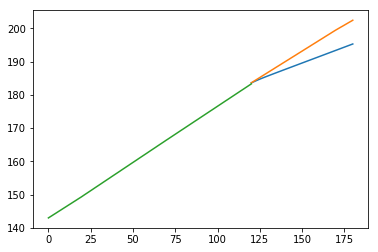

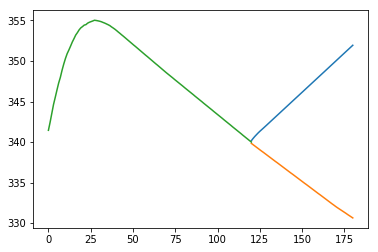

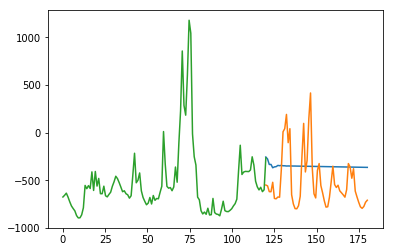

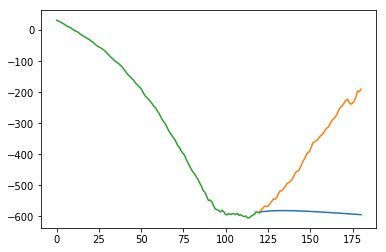

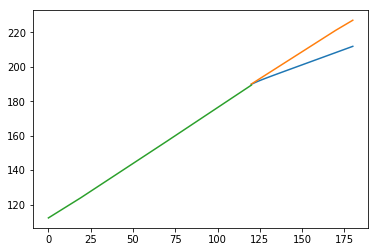

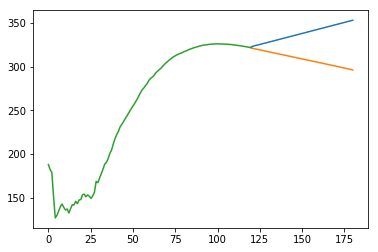

In [77]:
horizon = 60

allPredictions = []

i = 0
for (train, test) in trainingSets:    
    predictions = []
    history = [x for x in train]
    
    for t in range(horizon):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)

        output = model_fit.forecast()

        yhat = output[0]
        predictions.append(yhat)

#         obs = test[t]
        obs = yhat
        history.append(obs)

        print(str(t), end=', ')
        
    print()
    plt.figure()
    
    plt.plot(prev + np.linspace(0, horizon, horizon), predictions)
    plt.plot(prev + np.linspace(0, horizon, horizon), test[:horizon])

    plt.plot(np.linspace(0, prev, prev), train[-prev:])
    
    allPredictions.append(predictions)
    
    i += 1
    if i > 5:
        break

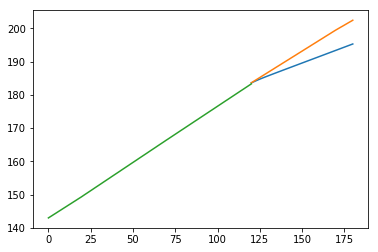

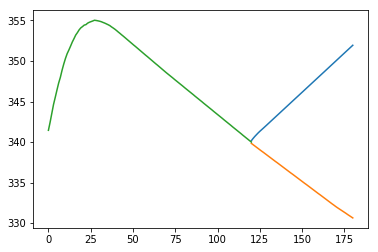

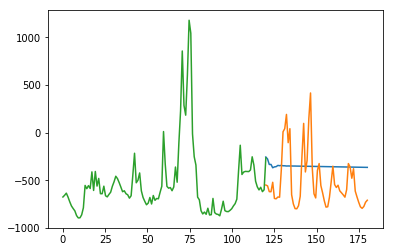

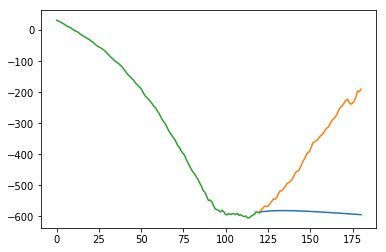

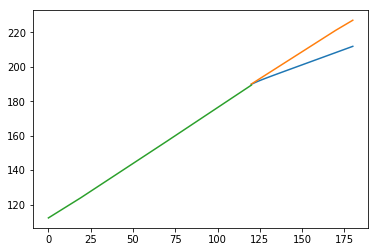

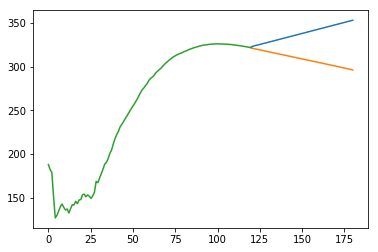

In [79]:
horizon = 60
prev = 120

for i, predictions in enumerate(allPredictions):
    train, test = trainingSets[i]
    
    plt.figure()
    
    plt.plot(prev + np.linspace(0, horizon, horizon), predictions)
    plt.plot(prev + np.linspace(0, horizon, horizon), test[:horizon])

    plt.plot(np.linspace(0, prev, prev), train[-prev:])

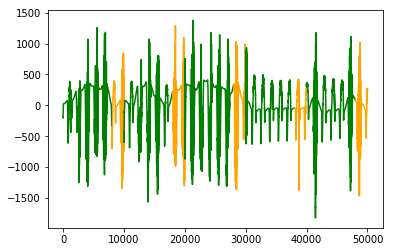

In [71]:
c= 0
for train, test in trainingSets:
    plt.plot(np.linspace(c, c + len(train), len(train)), train, c = 'green')
    plt.plot(np.linspace(c + len(train), c + len(train) + len(test), len(test)), test, c = 'orange')
    
    c += len(train) + len(test)